# Exploratory Data Preprocessing

Contributors: Simran Kaur

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 

In [2]:
# Read the csv file for QMOF dataset
df = pd.read_csv('../data/QMOF/qmof_database/qmof_database/qmof.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20374 entries, 0 to 20373
Data columns (total 94 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   qmof_id                             20374 non-null  object 
 1   name                                20374 non-null  object 
 2   info.formula                        20374 non-null  object 
 3   info.formula_reduced                20374 non-null  object 
 4   info.mofid.mofid                    7464 non-null   object 
 5   info.mofid.mofkey                   7697 non-null   object 
 6   info.mofid.smiles_nodes             17679 non-null  object 
 7   info.mofid.smiles_linkers           17546 non-null  object 
 8   info.mofid.smiles                   17679 non-null  object 
 9   info.mofid.topology                 7902 non-null   object 
 10  info.natoms                         20374 non-null  int64  
 11  info.pld                            20374

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/816009502.py:2: DtypeWarning: Columns (40,41,43,44,45,46,47,49,50,51,52,53,55,56,57,65,66,67,68,69,77,78,79,80,81,89,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/QMOF/qmof_database/qmof_database/qmof.csv', sep=',')


In [3]:
# Identify and remove duplicate rows
df = df.drop_duplicates()

columns_to_remove = [
    'name', 'info.formula', 'info.formula_reduced',
       'info.mofid.mofid', 'info.mofid.mofkey', 'info.mofid.smiles_nodes',
       'info.mofid.smiles_linkers', 'info.mofid.smiles', 'inputs.pbe.theory',
       'inputs.pbe.pseudopotentials', 'inputs.pbe.encut', 'inputs.pbe.kpoints',
       'inputs.pbe.gamma', 'inputs.hse06.theory',
       'inputs.hse06.pseudopotentials', 'inputs.hse06.encut', 'inputs.hse06.kpoints',
       'inputs.hse06.gamma', 'inputs.hle17.theory',
       'inputs.hle17.pseudopotentials', 'inputs.hle17.encut', 'inputs.hle17.kpoints',
       'inputs.hle17.gamma', 'inputs.hse06_10hf.theory',
       'inputs.hse06_10hf.pseudopotentials', 'inputs.hse06_10hf.encut', 'inputs.hse06_10hf.kpoints',
       'inputs.hse06_10hf.gamma'
] # Please update based on the columns you want to remove

df.drop(columns_to_remove, axis=1, inplace=True)
print(len(df.columns), 'columns remaining')

66 columns remaining


In [4]:
# Drop columns with more than 50% missing values
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)
print(len(df.columns), 'columns remaining')

65 columns remaining


['inputs.pbe', 'outputs.pbe', 'inputs.hle17', 'inputs.hse06_10hf', 'inputs.hse06', 'outputs.hle17', 'outputs.hse06_10hf', 'outputs.hse06']


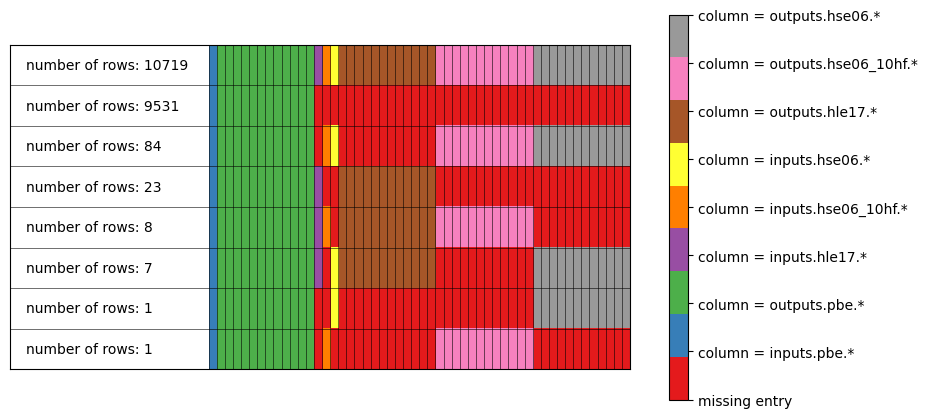

In [5]:
# separate 'info' columns from 'DFT input/output' columns
info_column_names = [cn for cn in df.columns if cn == 'qmof_id' or cn == 'name' or cn.startswith('info')]
dft_column_names = [cn for cn in df.columns if cn.startswith('inputs') or cn.startswith('outputs')]

# Do info_column_names and dft_column_names cover all columns?
set(info_column_names + dft_column_names) == set(df.columns)

# define a function to get the prefix of column name, i.e. part of the column name before the last '.' or the whole column name if it contains no '.'
def get_column_prefix(cn):
    if '.' in cn:
        return '.'.join(cn.split('.')[:-1])
    else:
        return cn

# list of unique DFT column  prefixes
dft_column_prefixes = list(dict.fromkeys([get_column_prefix(cn) for cn in dft_column_names]))
print(dft_column_prefixes)

# a data frame with the same shape as the original, restricted to the DFT columns, but with entries replaced with an index: 0 if the entry was NaN or a positive integer representing the column prefix if not
notna_column_prefix_id_df = pd.DataFrame(
   np.array([dft_column_prefixes.index(get_column_prefix(cn)) + 1 for cn in dft_column_names]).reshape(1,len(dft_column_names)).repeat(df.shape[0],axis=0),
    columns = dft_column_names
) * df[dft_column_names].notna()

# tally of idential rows in the above data frame (note: the tally is in the 'size' column of this data frame)
tally_inout_df = notna_column_prefix_id_df.groupby(dft_column_names,as_index=False).size().sort_values(by='size',ascending=False)

# plot the tally data frame as a image
plt.figure(figsize=(10,5))

plt.imshow(np.array(tally_inout_df)[:,:-1], cmap = 'Set1')
plt.xlim(left=-25)
for i, tally in enumerate(tally_inout_df['size']):
    plt.text(-23,i,'number of rows: ' + str(tally), verticalalignment = 'center')

ax = plt.gca()
ax.set_aspect(5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticks(np.arange(-.5,len(dft_column_names)+.5, 1), minor=True)
ax.set_yticks(np.arange(.5,7.5, 1), minor=True)
ax.tick_params(axis='both',which='minor',length=0)
plt.grid(visible=True, color='black', linewidth = .4, axis='both', which = 'minor')

cbar = plt.colorbar()
cbar.ax.set_yticks(np.arange(0, len(dft_column_prefixes)+1, 1))
cbar.ax.set_yticklabels(['missing entry'] + ['column = '+prefix+'.*' for prefix in dft_column_prefixes])

plt.show()

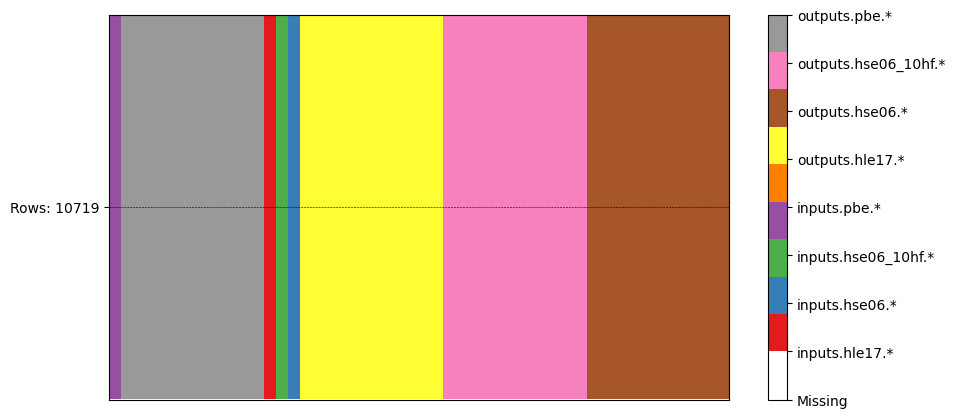

In [6]:
# Identify column groups
info_column_names = [cn for cn in df.columns if cn in {'qmof_id', 'name'} or cn.startswith('info')]
dft_column_names = [cn for cn in df.columns if cn.startswith(('inputs', 'outputs'))]

# Keep only rows where all DFT columns have values
df_clean = df.dropna(subset=dft_column_names)

# Function to extract prefix from column names
def get_column_prefix(cn):
    return '.'.join(cn.split('.')[:-1]) if '.' in cn else cn

# Get unique DFT column prefixes
dft_column_prefixes = sorted(set(get_column_prefix(cn) for cn in dft_column_names))

# Create a DataFrame indicating missing values (0) or prefix index (1+)
prefix_indices = {prefix: i + 1 for i, prefix in enumerate(dft_column_prefixes)}
notna_column_prefix_id_df = df_clean[dft_column_names].notna().astype(int) * [
    prefix_indices[get_column_prefix(cn)] for cn in dft_column_names
]

# Count unique row patterns
tally_inout_df = notna_column_prefix_id_df.groupby(dft_column_names).size().reset_index(name='size')
tally_inout_df = tally_inout_df.sort_values(by='size', ascending=False)

# Visualization
plt.figure(figsize=(10, 5))
plt.imshow(tally_inout_df.iloc[:, :-1], cmap='Set1', aspect='auto')
plt.xticks([])
plt.yticks(range(len(tally_inout_df)), [f'Rows: {s}' for s in tally_inout_df['size']])
plt.grid(True, linewidth=0.4, color='black', linestyle='--')

# Color bar
cbar = plt.colorbar()
cbar.set_ticks(range(len(dft_column_prefixes) + 1))
cbar.set_ticklabels(['Missing'] + [f'{p}.*' for p in dft_column_prefixes])

plt.show()

In [7]:
# Identify categorical columns (non-numerical)
categorical_columns = df_clean.select_dtypes(exclude=['number']).columns

# Display unique values for each categorical column
for col in categorical_columns:
    print(f"Column: {col}")
    print(df_clean[col].unique(), "\n")

Column: qmof_id
['qmof-644aab4' 'qmof-85a8986' 'qmof-07d3562' ... 'qmof-64eac3c'
 'qmof-92305e2' 'qmof-55d409b'] 

Column: info.symmetry.spacegroup
['P-1' 'P2_1/c' 'Pna2_1' 'P2_12_12' 'P2_1/m' 'Cc' 'C2/c' 'C2' 'Pbcn'
 'Pca2_1' 'P2_12_12_1' 'P2_1' 'Cmce' 'R-3' 'P2/c' 'Pbca' 'P6_3' 'C2/m'
 'Pm' 'Pnma' 'P1' 'I222' 'Pc' 'P4_2/n' 'Iba2' 'F222' 'P6_522' 'P-4n2'
 'Cmc2_1' 'Cmcm' 'Pnna' 'Fdd2' 'R3c' 'Ccc2' 'I-4m2' 'I4_1/a' 'Ibam' 'P4_3'
 'P6_1' 'Ima2' 'Pcca' 'Pmn2_1' 'P4_32_12' 'C222_1' 'Pccn' 'P3_121' 'Cmmm'
 'Cm' 'Pbcm' 'Pmna' 'Cmme' 'I23' 'P3_1' 'P4_12_12' 'Fddd' 'Pmma' 'P3_2'
 'I-4' 'Aea2' 'Ama2' 'Pcc2' 'Cccm' 'I2_12_12_1' 'P4_322' 'I-42d' 'P3_221'
 'P6_4' 'P-3c1' 'P-42_1m' 'Pmmn' 'I4/m' 'R3' 'P4/mcc' 'Pnnm' 'P222' 'P4_2'
 'P-3' 'I4_122' 'R-3c' 'R-3m' 'Immm' 'Pmc2_1' 'R3m' 'Pma2' 'Fd-3m'
 'P4_22_12' 'P4_1' 'Aem2' 'P6_3mc' 'Pba2' 'C222' 'P6_322' 'Pban' 'P2/m'
 'P-42_1c' 'Ibca' 'I4_1cd' 'I4' 'Pbam' 'Pnnn' 'P4/n' 'Imma' 'Pnc2' 'Fmmm'
 'R32' 'P4_2/mbc' 'Fm-3m' 'Cmm2' 'I-4c2' 'P6_3/m' 'P-4b2' '

In [8]:
more_columns_to_remove = [
    'info.doi', 'info.source', 'info.synthesized', 'info.symmetry.spacegroup', 'info.symmetry.pointgroup'
]
df_clean.drop(more_columns_to_remove, axis=1, inplace=True)
df_clean

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/2834996190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(more_columns_to_remove, axis=1, inplace=True)


,qmof_id,info.natoms,info.pld,info.lcd,info.density,info.volume,info.symmetry.spacegroup_number,info.symmetry.spacegroup_crystal,inputs.pbe.spin,outputs.pbe.energy_total,...,outputs.hse06.energy_elec,outputs.hse06.net_magmom,outputs.hse06.bandgap,outputs.hse06.cbm,outputs.hse06.vbm,outputs.hse06.directgap,outputs.hse06.bandgap_spins,outputs.hse06.cbm_spins,outputs.hse06.vbm_spins,outputs.hse06.directgap_spins
4,qmof-644aab4,102,1.33452,2.03948,1.596537,1148.155557,2,triclinic,False,-700.817715,...,-811.553859,0.0,2.901747,2.246703,-0.655044,True,"[None, None]","[None, None]","[None, None]","[None, None]"
13,qmof-85a8986,108,1.12484,2.84758,2.363811,1198.848870,14,monoclinic,False,-743.088583,...,-885.317539,0.0,3.742023,1.701769,-2.040254,True,"[None, None]","[None, None]","[None, None]","[None, None]"
26,qmof-07d3562,132,0.99905,1.95298,2.238027,1346.122104,33,orthorhombic,False,-830.110395,...,-988.564497,0.0,4.504094,2.941661,-1.562433,True,"[None, None]","[None, None]","[None, None]","[None, None]"
27,qmof-9883029,134,1.13178,2.11419,1.573802,1373.690229,14,monoclinic,False,-900.836887,...,-1044.620530,0.0,3.511018,3.183242,-0.327776,True,"[None, None]","[None, None]","[None, None]","[None, None]"
29,qmof-f224151,126,1.21638,2.69022,1.873856,1401.471537,18,orthorhombic,False,-790.570543,...,-907.691150,0.0,3.807474,2.708256,-1.099218,False,"[None, None]","[None, None]","[None, None]","[None, None]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,qmof-f73a75b,67,1.18551,2.89246,1.495041,707.036341,2,triclinic,False,-465.497706,...,-536.320647,0.0,2.518369,2.654818,0.136449,False,"[None, None]","[None, None]","[None, None]","[None, None]"
15954,qmof-600a106,66,1.37328,2.56785,1.711368,786.642474,7,monoclinic,False,-454.210595,...,-524.633244,0.0,2.149613,1.953162,-0.196451,False,"[None, None]","[None, None]","[None, None]","[None, None]"
15955,qmof-64eac3c,74,1.12322,2.17481,1.692097,755.001744,2,triclinic,False,-490.914004,...,-574.486836,0.0,3.956167,2.750360,-1.205807,True,"[None, None]","[None, None]","[None, None]","[None, None]"
15959,qmof-92305e2,100,1.01659,1.93464,1.892463,1095.155492,15,monoclinic,False,-686.567186,...,-807.094882,0.0,4.557899,3.212936,-1.344963,True,"[None, None]","[None, None]","[None, None]","[None, None]"


In [9]:
# Find columns that contain only True/False values
boolean_columns = [col for col in df_clean.columns if df_clean[col].dropna().isin([True, False]).all()]
print("Boolean Columns:", boolean_columns)
# Convert True/False to 1/0 only for boolean columns
df_clean[boolean_columns] = df_clean[boolean_columns].astype(int)
print(df_clean[boolean_columns].head())

Boolean Columns: ['inputs.pbe.spin', 'outputs.pbe.directgap', 'inputs.hle17.spin', 'inputs.hse06_10hf.spin', 'inputs.hse06.spin', 'outputs.hle17.energy_vdw', 'outputs.hle17.directgap', 'outputs.hse06_10hf.directgap', 'outputs.hse06.directgap']
    inputs.pbe.spin  outputs.pbe.directgap  inputs.hle17.spin  \
4                 0                      0                  0   
13                0                      1                  0   
26                0                      0                  0   
27                0                      1                  0   
29                0                      0                  0   

    inputs.hse06_10hf.spin  inputs.hse06.spin  outputs.hle17.energy_vdw  \
4                        0                  0                         0   
13                       0                  0                         0   
26                       0                  0                         0   
27                       0                  0                    

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/2179870807.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[boolean_columns] = df_clean[boolean_columns].astype(int)


In [10]:
from sklearn.preprocessing import OrdinalEncoder

# Define the order based on increasing symmetry constraints
crystal_order = [['triclinic', 'monoclinic', 'orthorhombic', 'tetragonal', 'trigonal', 'hexagonal', 'cubic']]

# Apply ordinal encoding
encoder = OrdinalEncoder(categories=crystal_order)
df_clean[['info.symmetry.spacegroup_crystal']] = encoder.fit_transform(df_clean[['info.symmetry.spacegroup_crystal']])

# Convert to integer (optional, for better readability)
df_clean['info.symmetry.spacegroup_crystal'] = df_clean['info.symmetry.spacegroup_crystal'].astype(int)

print(df_clean['info.symmetry.spacegroup_crystal'].unique())  # Should return numbers from 0 to 6

[0 1 2 4 5 3 6]


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/2539187643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['info.symmetry.spacegroup_crystal']] = encoder.fit_transform(df_clean[['info.symmetry.spacegroup_crystal']])
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/2539187643.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['info.symmetry.spacegroup_crystal'] = df_clean['info.symmetry.spacegroup_crystal'].astype(int)


In [11]:
import ast

# Function to convert string lists to actual lists
def parse_list_column(val):
    try:
        parsed_val = ast.literal_eval(val)  # Convert string to list
        return [float(x) if x is not None else np.nan for x in parsed_val]
    except:
        return [np.nan, np.nan]  # Handle errors safely

# Apply function to convert and split into two columns
for col in ['outputs.pbe.bandgap_spins', 'outputs.pbe.cbm_spins', 'outputs.pbe.vbm_spins', 'outputs.hle17.bandgap_spins', 'outputs.hle17.cbm_spins', 'outputs.hle17.vbm_spins', 'outputs.hse06_10hf.bandgap_spins', 'outputs.hse06_10hf.cbm_spins', 'outputs.hse06_10hf.vbm_spins', 'outputs.hse06.bandgap_spins', 'outputs.hse06.cbm_spins', 'outputs.hse06.vbm_spins']:
    df_clean[[f"{col}_spin1", f"{col}_spin2"]] = df_clean[col].apply(parse_list_column).apply(pd.Series)

# Drop the original column
df_clean.drop(columns=['outputs.pbe.bandgap_spins', 'outputs.pbe.cbm_spins', 'outputs.pbe.vbm_spins', 'outputs.hle17.bandgap_spins', 'outputs.hle17.cbm_spins', 'outputs.hle17.vbm_spins', 'outputs.hse06_10hf.bandgap_spins', 'outputs.hse06_10hf.cbm_spins', 'outputs.hse06_10hf.vbm_spins', 'outputs.hse06.bandgap_spins', 'outputs.hse06.cbm_spins', 'outputs.hse06.vbm_spins'], inplace=True)

df_clean

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/621223337.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[[f"{col}_spin1", f"{col}_spin2"]] = df_clean[col].apply(parse_list_column).apply(pd.Series)
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/621223337.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[[f"{col}_spin1", f"{col}_spin2"]] = df_clean[col].apply(parse_list_column).apply(pd.Series)
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipyke

,qmof_id,info.natoms,info.pld,info.lcd,info.density,info.volume,info.symmetry.spacegroup_number,info.symmetry.spacegroup_crystal,inputs.pbe.spin,outputs.pbe.energy_total,...,outputs.hse06_10hf.cbm_spins_spin1,outputs.hse06_10hf.cbm_spins_spin2,outputs.hse06_10hf.vbm_spins_spin1,outputs.hse06_10hf.vbm_spins_spin2,outputs.hse06.bandgap_spins_spin1,outputs.hse06.bandgap_spins_spin2,outputs.hse06.cbm_spins_spin1,outputs.hse06.cbm_spins_spin2,outputs.hse06.vbm_spins_spin1,outputs.hse06.vbm_spins_spin2
4,qmof-644aab4,102,1.33452,2.03948,1.596537,1148.155557,2,0,0,-700.817715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,qmof-85a8986,108,1.12484,2.84758,2.363811,1198.848870,14,1,0,-743.088583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,qmof-07d3562,132,0.99905,1.95298,2.238027,1346.122104,33,2,0,-830.110395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,qmof-9883029,134,1.13178,2.11419,1.573802,1373.690229,14,1,0,-900.836887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,qmof-f224151,126,1.21638,2.69022,1.873856,1401.471537,18,2,0,-790.570543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,qmof-f73a75b,67,1.18551,2.89246,1.495041,707.036341,2,0,0,-465.497706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15954,qmof-600a106,66,1.37328,2.56785,1.711368,786.642474,7,1,0,-454.210595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15955,qmof-64eac3c,74,1.12322,2.17481,1.692097,755.001744,2,0,0,-490.914004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15959,qmof-92305e2,100,1.01659,1.93464,1.892463,1095.155492,15,1,0,-686.567186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Convert directgap_spins column from string to actual lists

# Function to safely convert string lists to actual lists, handling None values
def parse_boolean_list(val):
    try:
        parsed_val = ast.literal_eval(val)  # Convert string to list
        return [1 if x is True else 0 if x is False else np.nan for x in parsed_val]  # Convert to 0/1/NaN
    except:
        return [np.nan, np.nan]  # Handle errors safely
    
df_clean[['outputs.pbe.directgap_spin1', 'outputs.pbe.directgap_spin2']] = (
    df_clean['outputs.pbe.directgap_spins'].apply(parse_boolean_list).apply(pd.Series)
)

df_clean[['outputs.hle17.directgap_spin1', 'outputs.hle17.directgap_spin2']] = (
    df_clean['outputs.hle17.directgap_spins'].apply(parse_boolean_list).apply(pd.Series)
)

df_clean[['outputs.hse06_10hf.directgap_spin1', 'outputs.hse06_10hf.directgap_spin2']] = (
    df_clean['outputs.hse06_10hf.directgap_spins'].apply(parse_boolean_list).apply(pd.Series)
)

df_clean[['outputs.hse06.directgap_spin1', 'outputs.hse06.directgap_spin2']] = (
    df_clean['outputs.hse06.directgap_spins'].apply(parse_boolean_list).apply(pd.Series)
)

# Convert to integers (0 = False, 1 = True)
df_clean[['outputs.pbe.directgap_spin1', 'outputs.pbe.directgap_spin2', 'outputs.hle17.directgap_spin1', 'outputs.hle17.directgap_spin2', 'outputs.hse06_10hf.directgap_spin1', 'outputs.hse06_10hf.directgap_spin2', 'outputs.hse06.directgap_spin1', 'outputs.hse06.directgap_spin2']] = (
    df_clean[['outputs.pbe.directgap_spin1', 'outputs.pbe.directgap_spin2',  'outputs.hle17.directgap_spin1', 'outputs.hle17.directgap_spin2', 'outputs.hse06_10hf.directgap_spin1', 'outputs.hse06_10hf.directgap_spin2', 'outputs.hse06.directgap_spin1', 'outputs.hse06.directgap_spin2']].apply(parse_boolean_list).apply(pd.Series)
)

# Drop the original column
df_clean.drop(columns=['outputs.pbe.directgap_spins', 'outputs.hle17.directgap_spins', 'outputs.hse06_10hf.directgap_spins', 'outputs.hse06.directgap_spins'], inplace=True)

print(df_clean.head())  # Check the result
df_clean

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/140422722.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['outputs.pbe.directgap_spin1', 'outputs.pbe.directgap_spin2']] = (
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/140422722.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['outputs.pbe.directgap_spin1', 'outputs.pbe.directgap_spin2']] = (
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/140422722.py:15: SettingWithCopyWarni

         qmof_id  info.natoms  info.pld  info.lcd  info.density  info.volume  \
4   qmof-644aab4          102   1.33452   2.03948      1.596537  1148.155557   
13  qmof-85a8986          108   1.12484   2.84758      2.363811  1198.848870   
26  qmof-07d3562          132   0.99905   1.95298      2.238027  1346.122104   
27  qmof-9883029          134   1.13178   2.11419      1.573802  1373.690229   
29  qmof-f224151          126   1.21638   2.69022      1.873856  1401.471537   

    info.symmetry.spacegroup_number  info.symmetry.spacegroup_crystal  \
4                                 2                                 0   
13                               14                                 1   
26                               33                                 2   
27                               14                                 1   
29                               18                                 2   

    inputs.pbe.spin  outputs.pbe.energy_total  ...  \
4                 0       

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/140422722.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['outputs.hse06.directgap_spin1', 'outputs.hse06.directgap_spin2']] = (
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/140422722.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[['outputs.hse06.directgap_spin1', 'outputs.hse06.directgap_spin2']] = (
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/140422722.py:28: SettingWithC

,qmof_id,info.natoms,info.pld,info.lcd,info.density,info.volume,info.symmetry.spacegroup_number,info.symmetry.spacegroup_crystal,inputs.pbe.spin,outputs.pbe.energy_total,...,outputs.hse06.vbm_spins_spin1,outputs.hse06.vbm_spins_spin2,outputs.pbe.directgap_spin1,outputs.pbe.directgap_spin2,outputs.hle17.directgap_spin1,outputs.hle17.directgap_spin2,outputs.hse06_10hf.directgap_spin1,outputs.hse06_10hf.directgap_spin2,outputs.hse06.directgap_spin1,outputs.hse06.directgap_spin2
4,qmof-644aab4,102,1.33452,2.03948,1.596537,1148.155557,2,0,0,-700.817715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,qmof-85a8986,108,1.12484,2.84758,2.363811,1198.848870,14,1,0,-743.088583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,qmof-07d3562,132,0.99905,1.95298,2.238027,1346.122104,33,2,0,-830.110395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,qmof-9883029,134,1.13178,2.11419,1.573802,1373.690229,14,1,0,-900.836887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,qmof-f224151,126,1.21638,2.69022,1.873856,1401.471537,18,2,0,-790.570543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,qmof-f73a75b,67,1.18551,2.89246,1.495041,707.036341,2,0,0,-465.497706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15954,qmof-600a106,66,1.37328,2.56785,1.711368,786.642474,7,1,0,-454.210595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15955,qmof-64eac3c,74,1.12322,2.17481,1.692097,755.001744,2,0,0,-490.914004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15959,qmof-92305e2,100,1.01659,1.93464,1.892463,1095.155492,15,1,0,-686.567186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Loop through each column and print unique values
for col in df_clean.columns:
    print(f"Column: {col}")
    print(df_clean[col].unique())  # Print unique values for the column
    print()  # Add a line break between columns for readability

Column: qmof_id
['qmof-644aab4' 'qmof-85a8986' 'qmof-07d3562' ... 'qmof-64eac3c'
 'qmof-92305e2' 'qmof-55d409b']

Column: info.natoms
[102 108 132 134 126  89 118  72  64 120  98 140  94 128 110 116 113 107
  84 136 146  90  85  78  92 122 112  65  66  74  58  54 150 106  86 144
 138 124 114  82 104  88  80  96  76  77  87  83  70 100  68  59  60  41
  24  36  39  56  40  50  67  75  62 148  44  95  48  53  25  27  52 121
  31  21  34  51  45  42  46  30  28  35 142  71 139  38 130  22  32 109
  81  61  37  55  73  43  29  91  63 117  33  79  57 133  93  26  49 129
  47 123  69  99 105  97 137 111 127 115 101 145 131 135  20 147 143 149
 103 141 125 119  17]

Column: info.pld
[1.33452 1.12484 0.99905 ... 1.37328 1.01659 1.28465]

Column: info.lcd
[2.03948 2.84758 1.95298 ... 2.17481 1.93464 1.95192]

Column: info.density
[1.59653732 2.36381104 2.23802737 ... 1.69209736 1.89246265 1.42098143]

Column: info.volume
[1148.155557  1198.84887   1346.122104  ...  755.0017441 1095.155492
  799

In [14]:
'outputs.pbe.bandgap_spins_spin1', 'outputs.pbe.bandgap_spins_spin2', 'outputs.pbe.cbm_spins_spin1', 'outputs.pbe.cbm_spins_spin2',
'outputs.pbe.vbm_spins_spin1', 'outputs.pbe.vbm_spins_spin2', 'outputs.hle17.bandgap_spins_spin1', 'outputs.hle17.bandgap_spins_spin2',
'outputs.hle17.cbm_spins_spin1', 'outputs.hle17.cbm_spins_spin2', 'outputs.hle17.vbm_spins_spin1', 'outputs.hle17.vbm_spins_spin2',
'outputs.hse06_10hf.bandgap_spins_spin1', 'outputs.hse06_10hf.bandgap_spins_spin2', 'outputs.hse06_10hf.cbm_spins_spin1', 'outputs.hse06_10hf.cbm_spins_spin2',
'outputs.hse06_10hf.vbm_spins_spin1', 'outputs.hse06_10hf.vbm_spins_spin2', 'outputs.hse06.bandgap_spins_spin1', 'outputs.hse06.bandgap_spins_spin2',
'outputs.hse06.cbm_spins_spin1', 'outputs.hse06.cbm_spins_spin2', 'outputs.hse06.vbm_spins_spin1', 'outputs.hse06.vbm_spins_spin2'

('outputs.hse06.cbm_spins_spin1',
 'outputs.hse06.cbm_spins_spin2',
 'outputs.hse06.vbm_spins_spin1',
 'outputs.hse06.vbm_spins_spin2')

In [15]:
some_more_columns_to_remove = [
    'outputs.pbe.directgap_spin1',
    'outputs.pbe.directgap_spin2',
    'outputs.hle17.directgap_spin1',
    'outputs.hle17.directgap_spin2',
    'outputs.hse06_10hf.directgap_spin1',
    'outputs.hse06_10hf.directgap_spin2',
    'outputs.hse06.directgap_spin1',
    'outputs.hse06.directgap_spin2'
]
df_clean.drop(some_more_columns_to_remove, axis=1, inplace=True)
df_clean

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/948325782.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(some_more_columns_to_remove, axis=1, inplace=True)


,qmof_id,info.natoms,info.pld,info.lcd,info.density,info.volume,info.symmetry.spacegroup_number,info.symmetry.spacegroup_crystal,inputs.pbe.spin,outputs.pbe.energy_total,...,outputs.hse06_10hf.cbm_spins_spin1,outputs.hse06_10hf.cbm_spins_spin2,outputs.hse06_10hf.vbm_spins_spin1,outputs.hse06_10hf.vbm_spins_spin2,outputs.hse06.bandgap_spins_spin1,outputs.hse06.bandgap_spins_spin2,outputs.hse06.cbm_spins_spin1,outputs.hse06.cbm_spins_spin2,outputs.hse06.vbm_spins_spin1,outputs.hse06.vbm_spins_spin2
4,qmof-644aab4,102,1.33452,2.03948,1.596537,1148.155557,2,0,0,-700.817715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,qmof-85a8986,108,1.12484,2.84758,2.363811,1198.848870,14,1,0,-743.088583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,qmof-07d3562,132,0.99905,1.95298,2.238027,1346.122104,33,2,0,-830.110395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,qmof-9883029,134,1.13178,2.11419,1.573802,1373.690229,14,1,0,-900.836887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,qmof-f224151,126,1.21638,2.69022,1.873856,1401.471537,18,2,0,-790.570543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,qmof-f73a75b,67,1.18551,2.89246,1.495041,707.036341,2,0,0,-465.497706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15954,qmof-600a106,66,1.37328,2.56785,1.711368,786.642474,7,1,0,-454.210595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15955,qmof-64eac3c,74,1.12322,2.17481,1.692097,755.001744,2,0,0,-490.914004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15959,qmof-92305e2,100,1.01659,1.93464,1.892463,1095.155492,15,1,0,-686.567186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Loop through each column and print unique values along with their counts
for col in df_clean.columns:
    print(f"Column: {col}")
    print(df_clean[col].value_counts(dropna=False))  # Include NaN values in the count
    print("\n" + "-"*50 + "\n")  # Add separator for readability

Column: qmof_id
qmof_id
qmof-644aab4    1
qmof-c49d30b    1
qmof-a03e4a5    1
qmof-e378426    1
qmof-c6b9ed2    1
               ..
qmof-14733c4    1
qmof-4c0ef7e    1
qmof-68afeea    1
qmof-ca905a4    1
qmof-55d409b    1
Name: count, Length: 10719, dtype: int64

--------------------------------------------------

Column: info.natoms
info.natoms
92     335
88     318
80     314
84     302
100    299
      ... 
125      2
21       1
149      1
145      1
17       1
Name: count, Length: 131, dtype: int64

--------------------------------------------------

Column: info.pld
info.pld
0.96671    5
0.91784    3
1.13615    3
1.17349    3
1.14771    3
          ..
1.76673    1
0.88831    1
1.02317    1
0.99953    1
1.28465    1
Name: count, Length: 10166, dtype: int64

--------------------------------------------------

Column: info.lcd
info.lcd
1.93739    3
1.94641    3
1.82730    3
2.49830    3
2.07677    3
          ..
2.04976    1
1.74398    1
2.27910    1
3.17595    1
1.95192    1
Name: c

In [17]:
# Interpolate for the Nan spin values

# Interpolate missing values using a polynomial (degree 2)
'''
df_clean[[
    'outputs.pbe.bandgap_spins_spin1', 'outputs.pbe.bandgap_spins_spin2', 'outputs.pbe.cbm_spins_spin1', 'outputs.pbe.cbm_spins_spin2',
'outputs.pbe.vbm_spins_spin1', 'outputs.pbe.vbm_spins_spin2', 'outputs.hle17.bandgap_spins_spin1', 'outputs.hle17.bandgap_spins_spin2',
'outputs.hle17.cbm_spins_spin1', 'outputs.hle17.cbm_spins_spin2', 'outputs.hle17.vbm_spins_spin1', 'outputs.hle17.vbm_spins_spin2',
'outputs.hse06_10hf.bandgap_spins_spin1', 'outputs.hse06_10hf.bandgap_spins_spin2', 'outputs.hse06_10hf.cbm_spins_spin1', 'outputs.hse06_10hf.cbm_spins_spin2',
'outputs.hse06_10hf.vbm_spins_spin1', 'outputs.hse06_10hf.vbm_spins_spin2', 'outputs.hse06.bandgap_spins_spin1', 'outputs.hse06.bandgap_spins_spin2',
'outputs.hse06.cbm_spins_spin1', 'outputs.hse06.cbm_spins_spin2', 'outputs.hse06.vbm_spins_spin1', 'outputs.hse06.vbm_spins_spin2'
]] = df_clean[
    ['outputs.pbe.bandgap_spins_spin1', 'outputs.pbe.bandgap_spins_spin2', 'outputs.pbe.cbm_spins_spin1', 'outputs.pbe.cbm_spins_spin2',
'outputs.pbe.vbm_spins_spin1', 'outputs.pbe.vbm_spins_spin2', 'outputs.hle17.bandgap_spins_spin1', 'outputs.hle17.bandgap_spins_spin2',
'outputs.hle17.cbm_spins_spin1', 'outputs.hle17.cbm_spins_spin2', 'outputs.hle17.vbm_spins_spin1', 'outputs.hle17.vbm_spins_spin2',
'outputs.hse06_10hf.bandgap_spins_spin1', 'outputs.hse06_10hf.bandgap_spins_spin2', 'outputs.hse06_10hf.cbm_spins_spin1', 'outputs.hse06_10hf.cbm_spins_spin2',
'outputs.hse06_10hf.vbm_spins_spin1', 'outputs.hse06_10hf.vbm_spins_spin2', 'outputs.hse06.bandgap_spins_spin1', 'outputs.hse06.bandgap_spins_spin2',
'outputs.hse06.cbm_spins_spin1', 'outputs.hse06.cbm_spins_spin2', 'outputs.hse06.vbm_spins_spin1', 'outputs.hse06.vbm_spins_spin2']
].interpolate(method='polynomial', order=2, axis=0)

df_clean'''

"\ndf_clean[[\n    'outputs.pbe.bandgap_spins_spin1', 'outputs.pbe.bandgap_spins_spin2', 'outputs.pbe.cbm_spins_spin1', 'outputs.pbe.cbm_spins_spin2',\n'outputs.pbe.vbm_spins_spin1', 'outputs.pbe.vbm_spins_spin2', 'outputs.hle17.bandgap_spins_spin1', 'outputs.hle17.bandgap_spins_spin2',\n'outputs.hle17.cbm_spins_spin1', 'outputs.hle17.cbm_spins_spin2', 'outputs.hle17.vbm_spins_spin1', 'outputs.hle17.vbm_spins_spin2',\n'outputs.hse06_10hf.bandgap_spins_spin1', 'outputs.hse06_10hf.bandgap_spins_spin2', 'outputs.hse06_10hf.cbm_spins_spin1', 'outputs.hse06_10hf.cbm_spins_spin2',\n'outputs.hse06_10hf.vbm_spins_spin1', 'outputs.hse06_10hf.vbm_spins_spin2', 'outputs.hse06.bandgap_spins_spin1', 'outputs.hse06.bandgap_spins_spin2',\n'outputs.hse06.cbm_spins_spin1', 'outputs.hse06.cbm_spins_spin2', 'outputs.hse06.vbm_spins_spin1', 'outputs.hse06.vbm_spins_spin2'\n]] = df_clean[\n    ['outputs.pbe.bandgap_spins_spin1', 'outputs.pbe.bandgap_spins_spin2', 'outputs.pbe.cbm_spins_spin1', 'outputs.pbe

In [18]:
# removing nan columns that came up 

even_more_columns_to_remove = [
    'outputs.pbe.bandgap_spins_spin1', 'outputs.pbe.bandgap_spins_spin2', 'outputs.pbe.cbm_spins_spin1', 'outputs.pbe.cbm_spins_spin2',
'outputs.pbe.vbm_spins_spin1', 'outputs.pbe.vbm_spins_spin2', 'outputs.hle17.bandgap_spins_spin1', 'outputs.hle17.bandgap_spins_spin2',
'outputs.hle17.cbm_spins_spin1', 'outputs.hle17.cbm_spins_spin2', 'outputs.hle17.vbm_spins_spin1', 'outputs.hle17.vbm_spins_spin2',
'outputs.hse06_10hf.bandgap_spins_spin1', 'outputs.hse06_10hf.bandgap_spins_spin2', 'outputs.hse06_10hf.cbm_spins_spin1', 'outputs.hse06_10hf.cbm_spins_spin2',
'outputs.hse06_10hf.vbm_spins_spin1', 'outputs.hse06_10hf.vbm_spins_spin2', 'outputs.hse06.bandgap_spins_spin1', 'outputs.hse06.bandgap_spins_spin2',
'outputs.hse06.cbm_spins_spin1', 'outputs.hse06.cbm_spins_spin2', 'outputs.hse06.vbm_spins_spin1', 'outputs.hse06.vbm_spins_spin2'
]
df_clean.drop(even_more_columns_to_remove, axis=1, inplace=True)
df_clean

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/3727890936.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(even_more_columns_to_remove, axis=1, inplace=True)


,qmof_id,info.natoms,info.pld,info.lcd,info.density,info.volume,info.symmetry.spacegroup_number,info.symmetry.spacegroup_crystal,inputs.pbe.spin,outputs.pbe.energy_total,...,outputs.hse06_10hf.vbm,outputs.hse06_10hf.directgap,outputs.hse06.energy_total,outputs.hse06.energy_vdw,outputs.hse06.energy_elec,outputs.hse06.net_magmom,outputs.hse06.bandgap,outputs.hse06.cbm,outputs.hse06.vbm,outputs.hse06.directgap
4,qmof-644aab4,102,1.33452,2.03948,1.596537,1148.155557,2,0,0,-700.817715,...,-0.331724,1,-819.609389,-8.05553,-811.553859,0.0,2.901747,2.246703,-0.655044,1
13,qmof-85a8986,108,1.12484,2.84758,2.363811,1198.848870,14,1,0,-743.088583,...,-1.288849,1,-893.128169,-7.81063,-885.317539,0.0,3.742023,1.701769,-2.040254,1
26,qmof-07d3562,132,0.99905,1.95298,2.238027,1346.122104,33,2,0,-830.110395,...,-1.013182,1,-999.058147,-10.49365,-988.564497,0.0,4.504094,2.941661,-1.562433,1
27,qmof-9883029,134,1.13178,2.11419,1.573802,1373.690229,14,1,0,-900.836887,...,-0.049367,1,-1053.512470,-8.89194,-1044.620530,0.0,3.511018,3.183242,-0.327776,1
29,qmof-f224151,126,1.21638,2.69022,1.873856,1401.471537,18,2,0,-790.570543,...,-0.713820,0,-917.031180,-9.34003,-907.691150,0.0,3.807474,2.708256,-1.099218,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,qmof-f73a75b,67,1.18551,2.89246,1.495041,707.036341,2,0,0,-465.497706,...,0.878483,0,-541.910427,-5.58978,-536.320647,0.0,2.518369,2.654818,0.136449,0
15954,qmof-600a106,66,1.37328,2.56785,1.711368,786.642474,7,1,0,-454.210595,...,0.363668,0,-529.834574,-5.20133,-524.633244,0.0,2.149613,1.953162,-0.196451,0
15955,qmof-64eac3c,74,1.12322,2.17481,1.692097,755.001744,2,0,0,-490.914004,...,-0.824396,1,-579.683316,-5.19648,-574.486836,0.0,3.956167,2.750360,-1.205807,1
15959,qmof-92305e2,100,1.01659,1.93464,1.892463,1095.155492,15,1,0,-686.567186,...,-0.994570,1,-814.476972,-7.38209,-807.094882,0.0,4.557899,3.212936,-1.344963,1


In [19]:
df_clean.describe()

,info.natoms,info.pld,info.lcd,info.density,info.volume,info.symmetry.spacegroup_number,info.symmetry.spacegroup_crystal,inputs.pbe.spin,outputs.pbe.energy_total,outputs.pbe.energy_vdw,...,outputs.hse06_10hf.vbm,outputs.hse06_10hf.directgap,outputs.hse06.energy_total,outputs.hse06.energy_vdw,outputs.hse06.energy_elec,outputs.hse06.net_magmom,outputs.hse06.bandgap,outputs.hse06.cbm,outputs.hse06.vbm,outputs.hse06.directgap
count,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,...,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000,10719.000000
mean,86.086855,1.279554,2.406880,2.011207,948.175218,13.240974,0.723855,0.198899,-565.189414,-7.405954,...,-0.286646,0.533259,-668.978250,-6.818059,-662.160190,0.609572,3.865956,3.004039,-0.861917,0.536804
std,29.775082,0.780098,0.946061,0.481778,352.530412,22.015564,0.778430,0.399191,200.874984,2.549496,...,0.931345,0.498916,235.927901,2.406639,233.907607,2.579634,1.061227,0.949094,0.930793,0.498667
min,17.000000,0.000000,0.783710,0.578619,193.351392,1.000000,0.000000,0.000000,-1113.542285,-19.710460,...,-5.591167,0.000000,-1330.114291,-20.311420,-1318.494701,0.000000,0.007852,-2.176773,-5.964339,0.000000
25%,64.000000,0.925895,1.848760,1.675563,693.276887,2.000000,0.000000,0.000000,-698.161665,-8.986330,...,-0.907218,0.000000,-824.576867,-8.226325,-816.717652,0.000000,3.207157,2.420341,-1.446802,0.000000
50%,84.000000,1.077080,2.147430,1.912346,909.356324,12.000000,1.000000,0.000000,-552.793313,-7.186770,...,-0.378134,1.000000,-656.524927,-6.591040,-649.182628,0.000000,3.822756,2.946146,-0.925942,1.000000
75%,106.000000,1.307075,2.658560,2.263287,1173.764323,14.000000,1.000000,0.000000,-416.179215,-5.595450,...,0.262171,1.000000,-494.763199,-5.110295,-489.595917,0.000000,4.441210,3.557526,-0.314816,1.000000
max,150.000000,16.269400,16.354980,5.436020,4419.428866,227.000000,6.000000,1.000000,-117.655125,-1.651580,...,3.179348,1.000000,-140.139780,-1.477580,-137.994830,40.000000,8.181944,7.180214,3.214033,1.000000


/Users/simran/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


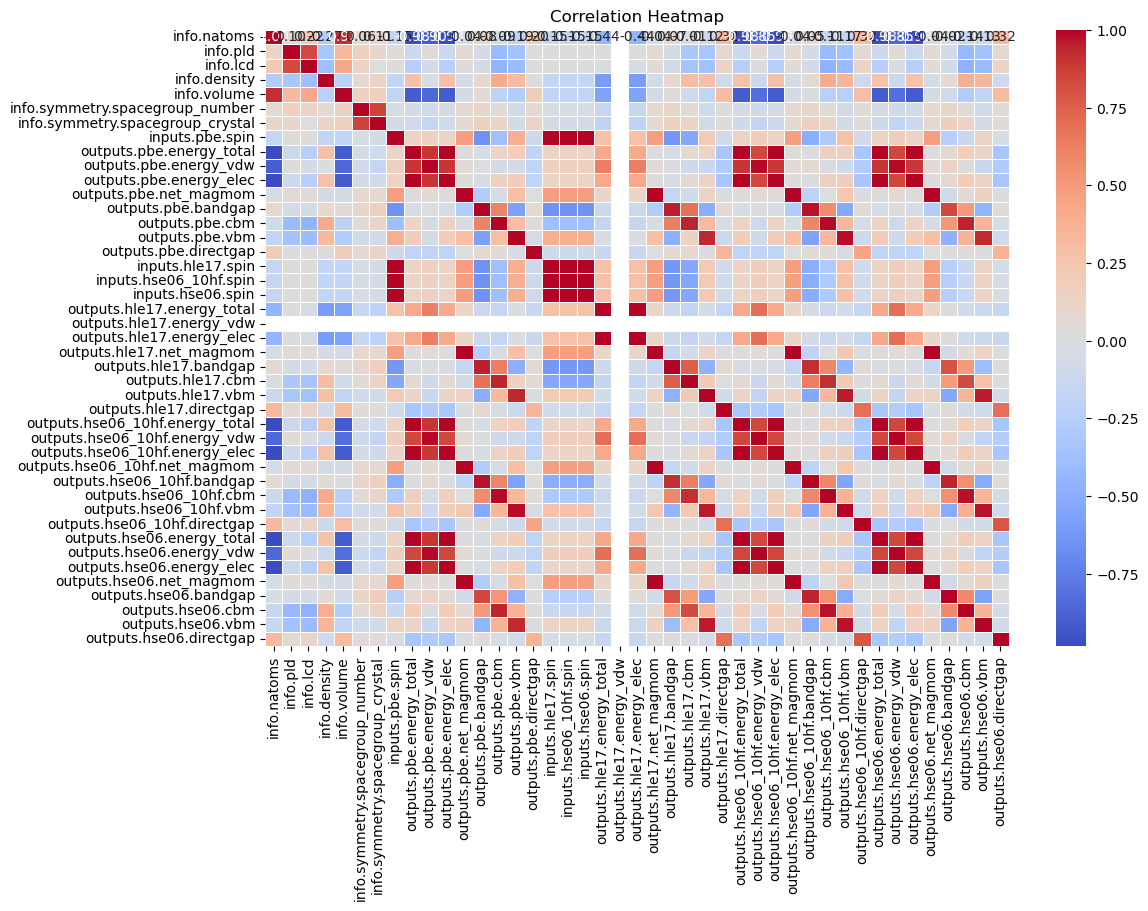

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(df_clean.iloc[:, 1:].corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 10})
plt.title("Correlation Heatmap")

# Rotate labels for better visibility
plt.yticks(rotation=0)  

plt.show()

In [21]:
df_clean.columns

Index(['qmof_id', 'info.natoms', 'info.pld', 'info.lcd', 'info.density',
       'info.volume', 'info.symmetry.spacegroup_number',
       'info.symmetry.spacegroup_crystal', 'inputs.pbe.spin',
       'outputs.pbe.energy_total', 'outputs.pbe.energy_vdw',
       'outputs.pbe.energy_elec', 'outputs.pbe.net_magmom',
       'outputs.pbe.bandgap', 'outputs.pbe.cbm', 'outputs.pbe.vbm',
       'outputs.pbe.directgap', 'inputs.hle17.spin', 'inputs.hse06_10hf.spin',
       'inputs.hse06.spin', 'outputs.hle17.energy_total',
       'outputs.hle17.energy_vdw', 'outputs.hle17.energy_elec',
       'outputs.hle17.net_magmom', 'outputs.hle17.bandgap',
       'outputs.hle17.cbm', 'outputs.hle17.vbm', 'outputs.hle17.directgap',
       'outputs.hse06_10hf.energy_total', 'outputs.hse06_10hf.energy_vdw',
       'outputs.hse06_10hf.energy_elec', 'outputs.hse06_10hf.net_magmom',
       'outputs.hse06_10hf.bandgap', 'outputs.hse06_10hf.cbm',
       'outputs.hse06_10hf.vbm', 'outputs.hse06_10hf.directgap',
     

In [22]:
# Out of correlated columns, keep one and remove rest
correlated_columns_to_remove = [
    'inputs.pbe.spin', 'inputs.hle17.spin', 'inputs.hse06.spin', 'inputs.hse06_10hf.spin',
    'outputs.pbe.energy_vdw', 'outputs.pbe.energy_elec', 
    'outputs.hle17.energy_vdw', 'outputs.hle17.energy_elec',
    'outputs.hse06.energy_vdw', 'outputs.hse06.energy_elec',
    'outputs.hse06_10hf.energy_vdw', 'outputs.hse06_10hf.energy_elec', 'info.lcd', 'info.symmetry.spacegroup_crystal', 'info.volume',
    'outputs.pbe.cbm', 'outputs.hle17.cbm', 'outputs.hse06.cbm', 'outputs.hse06_10hf.cbm', 
    'outputs.hle17.net_magmom', 'outputs.hse06_10hf.net_magmom', 'outputs.hse06.net_magmom', 
    'outputs.hse06_10hf.energy_total', 'outputs.hse06.energy_total'
]
df_clean.drop(correlated_columns_to_remove, axis=1, inplace=True)

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/1695583864.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(correlated_columns_to_remove, axis=1, inplace=True)


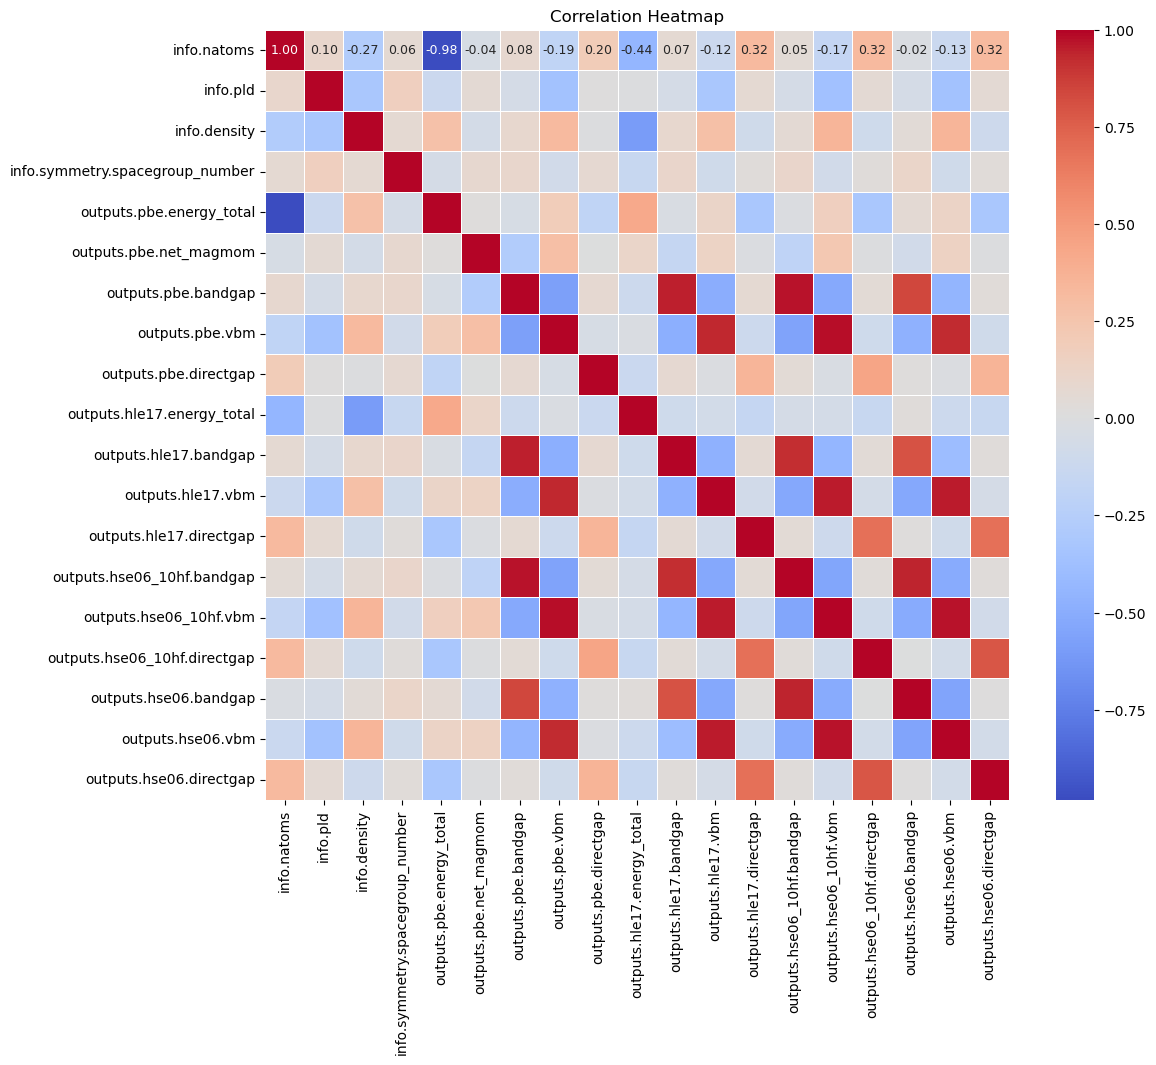

In [25]:
plt.figure(figsize=(12,10))
sns.heatmap(df_clean.iloc[:, 1:].corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 9})
plt.title("Correlation Heatmap")
plt.show()


In [26]:
correlated_columns_to_remove1 = [
    'info.natoms', 'outputs.hle17.bandgap', 'outputs.hse06.bandgap', 'outputs.hse06_10hf.bandgap',
    'outputs.hle17.vbm', 'outputs.hse06.vbm', 'outputs.hse06_10hf.vbm'
    
    
]
df_clean.drop(correlated_columns_to_remove1, axis=1, inplace=True)

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_13108/3829188256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(correlated_columns_to_remove1, axis=1, inplace=True)


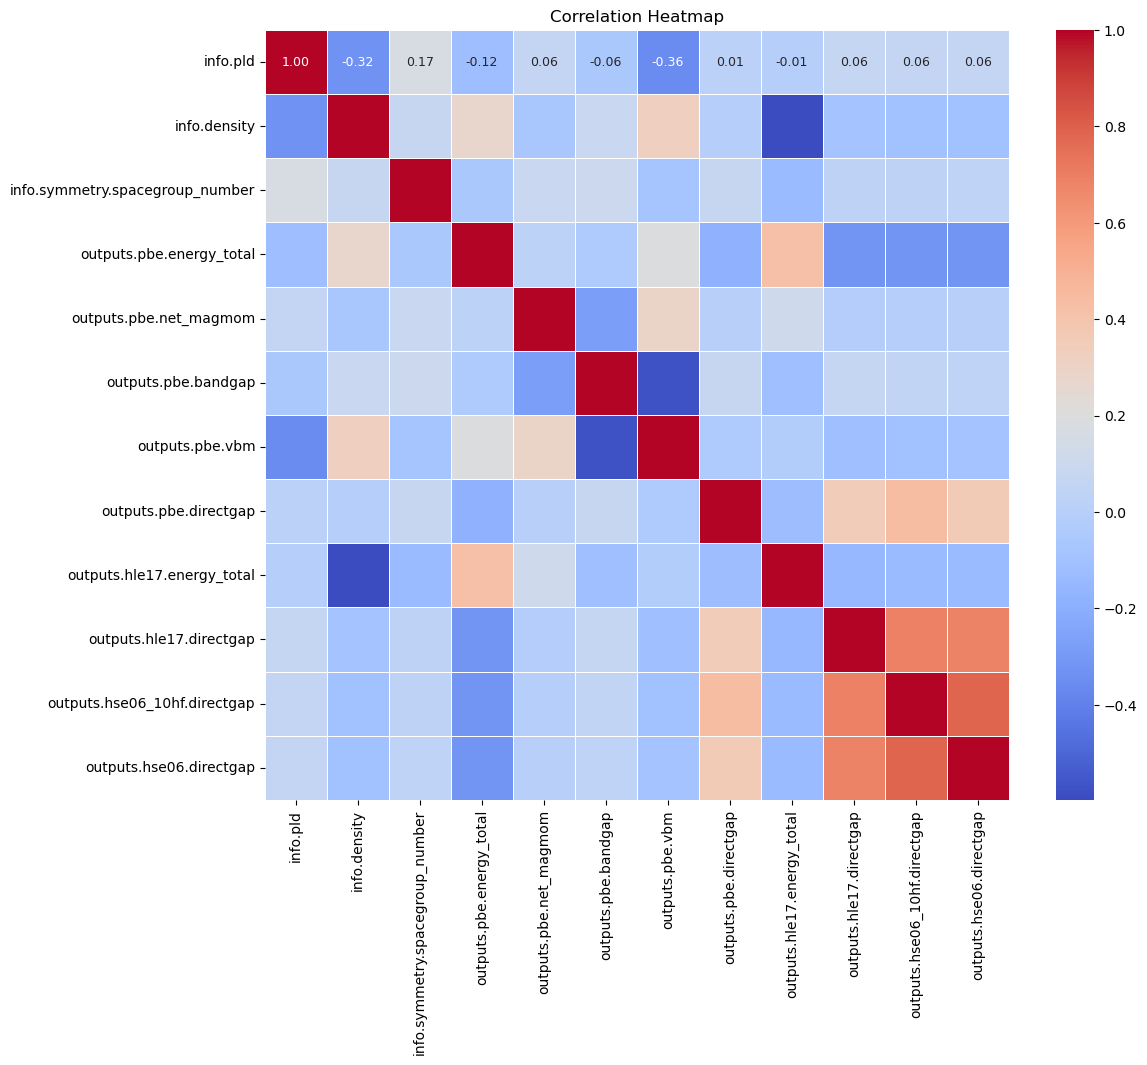

In [27]:
plt.figure(figsize=(12,10))
sns.heatmap(df_clean.iloc[:, 1:].corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 9})
plt.title("Correlation Heatmap")
plt.show()


In [28]:
df_clean

,qmof_id,info.pld,info.density,info.symmetry.spacegroup_number,outputs.pbe.energy_total,outputs.pbe.net_magmom,outputs.pbe.bandgap,outputs.pbe.vbm,outputs.pbe.directgap,outputs.hle17.energy_total,outputs.hle17.directgap,outputs.hse06_10hf.directgap,outputs.hse06.directgap
4,qmof-644aab4,1.33452,1.596537,2,-700.817715,0.0,1.973007,-0.117998,0,-4801.212415,1,1,1
13,qmof-85a8986,1.12484,2.363811,14,-743.088583,0.0,2.136836,-0.799162,1,-10991.417330,1,1,1
26,qmof-07d3562,0.99905,2.238027,33,-830.110395,0.0,3.083551,-0.499318,0,-10314.014390,1,1,1
27,qmof-9883029,1.13178,1.573802,14,-900.836887,0.0,2.679965,0.134145,1,-6100.895382,1,1,1
29,qmof-f224151,1.21638,1.873856,18,-790.570543,0.0,2.786405,-0.431550,0,-9990.145760,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15951,qmof-f73a75b,1.18551,1.495041,2,-465.497706,0.0,0.887507,1.333091,0,-2647.347399,0,0,0
15954,qmof-600a106,1.37328,1.711368,7,-454.210595,0.0,0.975490,0.694100,0,-3866.410864,0,0,0
15955,qmof-64eac3c,1.12322,1.692097,2,-490.914004,0.0,2.960569,-0.569639,0,-3375.495561,1,1,1
15959,qmof-92305e2,1.01659,1.892463,15,-686.567186,0.0,3.501637,-0.728738,0,-6672.888571,1,1,1
